# GPS timing

This notebook shows how to process the output of [GNSS-DSP-tools](https://github.com/pmonta/GNSS-DSP-tools) to measure the time of transmission of a GPS signal.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

plt.rcParams['font.size'] = 14
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.figsize'] = (10, 5)

Some parameters:

In [2]:
chip_rate = 1.023e6  # GPS L1 C/A chip rate
samp_rate = 4e6  # This should match the IQ recording sample rate

The `track-gps-l1.py` script skips some samples at the beginning of the IQ file in order to start at the beginning of a PRN repetition. Here we calculate how many samples were skipped.

In [3]:
code_offset = 151.6  # This should match the code offset used in track-gps-l1.py

samples_skipped = int(samp_rate*0.001*((1023-code_offset)/1023))
samples_skipped

3407

Read some of the columns of the output of `track-gps-l1.py` into numpy arrays.

In [4]:
with open('track.txt') as f:
    track = f.readlines()

iq = np.array([float(a.split()[1]) + 1j*float(a.split()[2]) for a in track])
samp = np.array([int(a.split()[-1]) for a in track]) + samples_skipped
carrier_f = np.array([float(a.split()[3]) for a in track])
code_cyc = np.array([int(a.split()[-5]) for a in track])
code_p = np.array([float(a.split()[-4]) for a in track])

samp_seconds = samp / samp_rate

The carrier frequency can be used to check if the tracking loops are locked. After a second or so, the carrier frequency should follow the Doppler of the satellite (plus receiver clock drift).

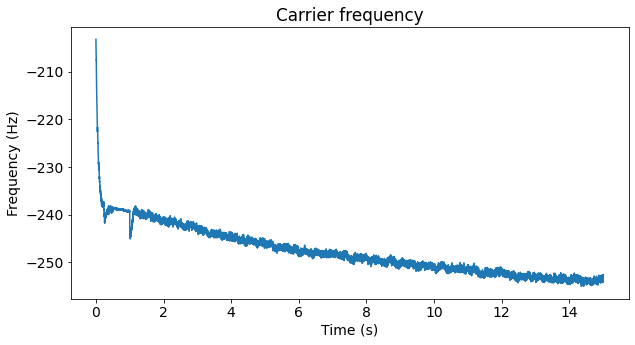

In [5]:
plt.plot(samp_seconds, carrier_f)
plt.title('Carrier frequency')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)');

The IQ dumps from the integrate & dump output also indicate the quality of the tracking, and we will use them to find the start of the subframes and read the TOW (time on week).

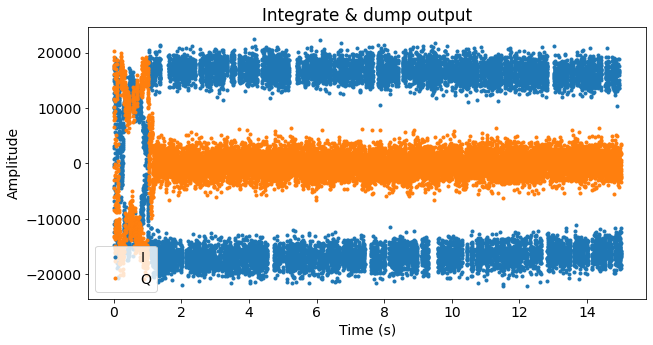

In [6]:
plt.plot(samp_seconds, iq.real, '.', label='I')
plt.plot(samp_seconds, iq.imag, '.', label='Q')
plt.title('Integrate & dump output')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude');

Symbols are 20 dumps long. We find where symbols start by integrating the symbols for all possible offsets and choosing the one that maximizes the amplitude.

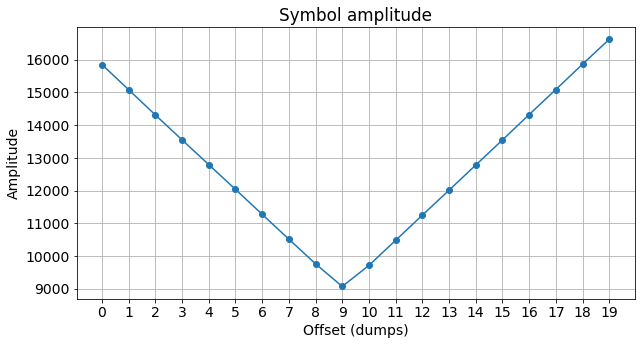

In [7]:
t0 = 8000  # Use data mid-way the recording
length = 4000  # Use only 4 seconds of data
dumps_per_symbol = 20
symbol_sums = np.empty(dumps_per_symbol)
for j in range(dumps_per_symbol):
    symbols = np.average(iq.real[t0+j:][:length].reshape(-1, dumps_per_symbol),
                         axis=1)
    symbol_sums[j] = np.average(np.abs(symbols))

plt.plot(symbol_sums, 'o-')
plt.xticks(np.arange(dumps_per_symbol))
plt.grid()
plt.xlabel('Offset (dumps)')
plt.ylabel('Amplitude')
plt.title('Symbol amplitude');

The offset at which symbols start is given by the peak in the plot above.

In [8]:
symbol_offset = np.argmax(symbol_sums)
symbol_offset

19

We now integrate and plot the symbols.

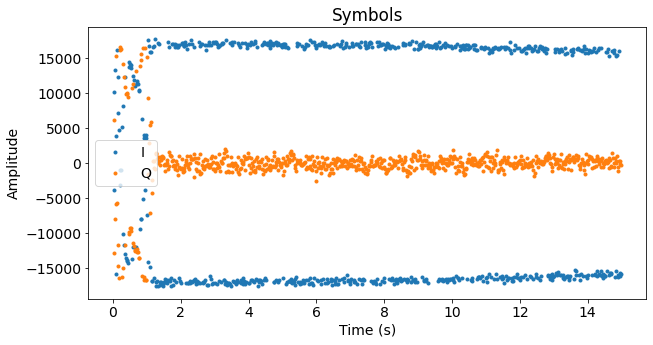

In [9]:
symbols = iq[symbol_offset:]
symbols = symbols[:symbols.size//dumps_per_symbol*dumps_per_symbol]
symbols = np.average(symbols.reshape(-1, dumps_per_symbol), axis=1)

symbols_seconds = samp_seconds[symbol_offset:][::dumps_per_symbol][:symbols.size]

plt.plot(symbols_seconds, symbols.real, '.', label='I')
plt.plot(symbols_seconds, symbols.imag, '.', label='Q')
plt.title('Symbols')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude');

We compute and plot the correlation between the bits (the sign of the real part of the symbols) and the 8-bit preamble that is transmitted at the beginning of each 6-second subframe. Finding the beginning of the subframes is tricky because this 8-bit pattern can also occur elsewhere, and the bit stream may be inverted (due to 180º phase ambiguity in the Costas loop).

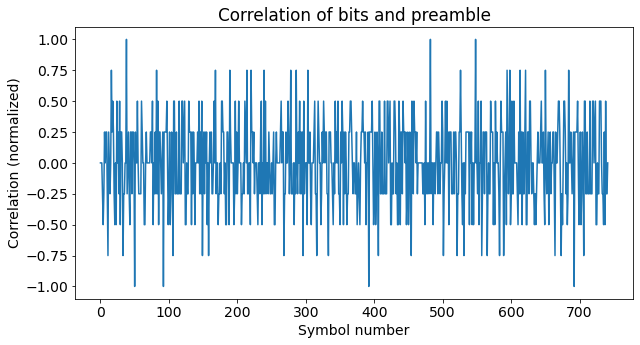

In [10]:
preamble = 2*np.array([1, 0, 0, 0, 1, 0, 1, 1]) - 1
bits = np.sign(symbols.real)
corr_preamble = np.correlate(bits, preamble) / preamble.size
plt.plot(corr_preamble)
plt.title('Correlation of bits and preamble')
plt.ylabel('Correlation (normalized)')
plt.xlabel('Symbol number');

We try to search for correlations that achieve the maximum amplitude and that differ by 300 symbols (6 seconds) to guess which correlations really correspond to the preamble.

In [11]:
np.where(corr_preamble == 1)[0]

array([ 38, 482, 548])

In [12]:
np.where(corr_preamble == -1)[0]

array([ 50,  92, 392, 692])

In [13]:
preamble_start = 92

To get the TOW, we need to read a 17-bit number somewhere in the subframe (in the 2nd word of the subframe), and XOR it with the last bit of the previous word. The TOW is given in units of 6 seconds, so we multiply it by 6 to obtain seconds.

In [14]:
def get_tow(bits, preamble_start):
    # handle inversion according to the last bit of the previous word
    tow = bits[preamble_start + 30:][:17] * (-1) * bits[preamble_start + 29]
    tow = ((tow + 1) / 2).astype('uint8')
    tow = np.packbits(tow)
    tow = ((np.int32(tow[0]) << 16) | (np.int32(tow[1]) << 8) | np.int32(tow[2])) >> 7
    tow = tow * 6
    return tow

We get the TOWs of two subframes to check that we're reading it correctly. The two TOWs should differ by 6 seconds.

In [15]:
tow0 = get_tow(bits, preamble_start)
tow0

41550

In [16]:
tow1 = get_tow(bits, preamble_start + 300)
tow1

41556

We now compute the TOW at the first dump in the `track-gps-l1.py` output, taking into account that the TOW given in a subframe corresponds to the TOW at the start of the next subframe, and counting in which dump this subframe starts.

In [17]:
# 6 seconds accounts for the fact that the TOW field
# gives the TOW at the start of the next subframe
tow_first_dump = tow0 - 6 - preamble_start / 50 - symbol_offset / 1000

tow_first_dump

41542.141

We now decompose the TOW as (day of week, hour, minute, seconds). This also serves as a cross-check to see if we have calculated it correctly. Remember that GPS time is ahead of UTC by 18 seconds.

In [18]:
(tow_first_dump // (24 * 3600), (tow_first_dump % (24 * 3600)) // 3600,
 (tow_first_dump % 3600) // 60, tow_first_dump % 60)

(0.0, 11.0, 32.0, 22.14100000000326)

The unwrapped code phase counts how the satellite transmission time (with an initial ambiguity of 1ms) evolves over time. Since the DLL takes some seconds to lock, the measurement is not accurate over the first seconds.

In [19]:
code_chips = code_cyc + code_p
code_secs = code_chips / chip_rate

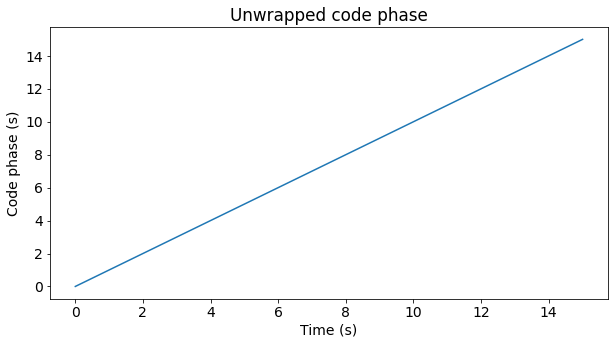

In [20]:
plt.plot(samp_seconds, code_secs)
plt.ylabel('Code phase (s)')
plt.xlabel('Time (s)')
plt.title('Unwrapped code phase');

We fit a polynomial of degree 2 ignoring the first 5 seconds in order to extrapolate back a more accurate value for the code phase at the start of the recording.

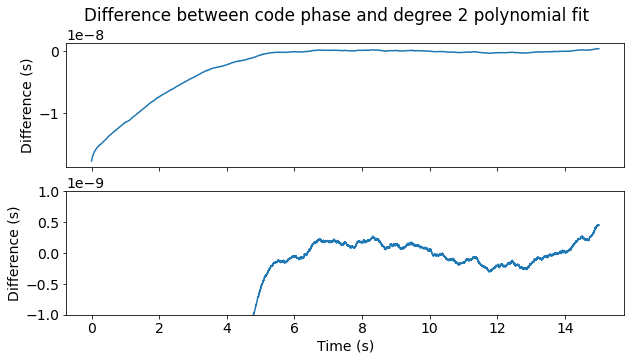

In [21]:
sel_fit = samp_seconds >= 5
poly_code = np.polyfit(samp_seconds[sel_fit], code_secs[sel_fit], 2)
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(samp_seconds, code_secs - np.polyval(poly_code, samp_seconds))
axs[1].plot(samp_seconds, code_secs - np.polyval(poly_code, samp_seconds))
axs[1].set_ylim((-1e-9, 1e-9))
axs[0].set_ylabel('Difference (s)')
axs[1].set_ylabel('Difference (s)')
plt.xlabel('Time (s)')
plt.suptitle('Difference between code phase and degree 2 polynomial fit');

A sanity check for the extrapolated code phase at the start of the recording. In units of chips it should be close to the code offset that we have indicated to `track-gps-l1.py`.

In [22]:
(np.polyval(poly_code, 0) % 1e-3) * chip_rate - code_offset

0.01842162524863511

We use this extrapolation and the TOW at the first dump to compute the satellite transmission time at the beginning of the recording.

In [23]:
# Here -1e-3 accounts for the fact that code_secs starts counting
# at the PRN repetition that starts just before the recording start,
# while tow_first_dump refers to the first PRN repetition that starts
# after the recording start.
tx_time_start = np.polyval(poly_code, 0) + tow_first_dump - 1e-3
tx_time_start

41542.140148209604

Now we use the `compute` binary, which uses [RTKLIB](http://www.rtklib.com/) to compute the time of flight of the signal of the satellite at the start of the recording, using the known position of the antenna and the satellite ephemerides. The calculated time of flight is inserted here and used to derive the GPS time at the start of the recording.

In [24]:
time_of_flight = 0.074602692582
gps_time_start = tx_time_start + time_of_flight
gps_time_start

41542.21475090219

We now compare the GPS time with the timestamp that UHD has included in the recording metadata using the PPS synchronization (we have converted it to TOW taking into account the 18 second difference between GPS and UTC).

In [25]:
usrp_timestamp = 41542.2147593125

gps_time_start - usrp_timestamp

-8.410308510065079e-06

Another cross-check. Now that we know that the UHD timestamp is reasonably accurate, we use it to compute the time of flight of each satellite at the beginning of the recording. We check the difference between the code offset reported by `acquire-gps-l1.py` and the code offset computed by subtracting from the UHD timestamp the time of flight. We show the result in units of chips. All the satellites should show a very similar result (with a fraction of a chip). Moreover, the results should be small (a few chips), since the UHD timestamp error is a few microseconds.

Note that G11, which was marked as unhealthy, is off by ~2 chips.

In [26]:
# G02
tf0_2 = 0.079009097743
code_offset2 = 758.8
(usrp_timestamp - tf0_2) % 1e-3 * 1.023e6 - code_offset2

8.669689561791756

In [27]:
# G11
tf0_11 = 0.078571217012
code_offset11 = 185.8
(usrp_timestamp - tf0_11) % 1e-3 * 1.023e6 - code_offset11

6.621681735121626

In [28]:
# G12
tf0_12 = 0.074602813604
code_offset12 = 151.6
(usrp_timestamp - tf0_12) % 1e-3 * 1.023e6 - code_offset12

8.498365512191697

In [29]:
# G22
tf0_22 = 0.073296200402
code_offset22 = 465.0
(usrp_timestamp - tf0_22) % 1e-3 * 1.023e6 - code_offset22

8.763670595634608

In [30]:
# G25
tf0_25 = 0.067335350355
code_offset25 = 425.1
(usrp_timestamp - tf0_25) % 1e-3 * 1.023e6 - code_offset25

8.613274160846345

In [31]:
# G31
tf0_31 = 0.074203745832
code_offset31 = 559.7
(usrp_timestamp - tf0_31) % 1e-3 * 1.023e6 - code_offset31

8.644696654627865

In [32]:
# G32
tf0_32 = 0.073085740178
code_offset32 = 680.3
(usrp_timestamp - tf0_32) % 1e-3 * 1.023e6 - code_offset32

8.764480238574947